<a href="https://colab.research.google.com/github/mifm/examples/blob/master/test_sens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
%%capture
!pip install topfarm

In [14]:
import numpy as np
from py_wake.examples.data.iea37._iea37 import IEA37_WindTurbines, IEA37Site
from py_wake.deficit_models.gaussian import IEA37SimpleBastankhahGaussian
from topfarm.cost_models.economic_models.dtu_wind_cm_main import economic_evaluation as ee_2

50.0
243670029.00515404
21.639770607791608
0.018882519748510088

65.0
234461544.74851143
19.976001706769587
0.020046645966031593

90.0
218960152.4177442
17.035754689358917
0.02249469482826575



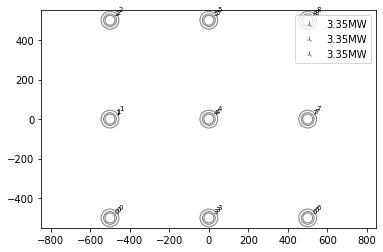

In [15]:
# site set up
n_wt = 9 # number of wind turbines
site = IEA37Site(n_wt) # site is the IEA Wind Task 37 site with a circle boundary
windTurbines = IEA37_WindTurbines() # wind turbines are the IEA Wind Task 37 3.4 MW reference turbine
wake_model = IEA37SimpleBastankhahGaussian(site, windTurbines) # select the Gaussian wake model

# vectors for turbine properties: diameter, rated power and hub height
# these are inputs to the cost model
diameters = [50, 65, 90]
for d in diameters:
    windTurbines._diameters[0] = d
    Drotor_vector = [windTurbines.diameter()] * n_wt 
    power_rated_vector = [float(windTurbines.power(20))*1e-6] * n_wt 
    hub_height_vector = [windTurbines.hub_height()] * n_wt 
    
    # add additional cost model inputs for shore distance, energy price, project lifetime, rated rotor speed and water depth
    distance_from_shore = 30         # [km]
    energy_price = 0.1               # [Euro/kWh] What we get per kWh
    project_duration = 20            # [years]    
    rated_rpm_array = [12] * n_wt    # [rpm]
    water_depth_array = [15] * n_wt  # [m]
    
    # set up function for new cost model with initial inputs as set above
    eco_eval = ee_2(distance_from_shore, energy_price, project_duration)
    
    # calculate aep as a function of x,y positions of the wind turbiens
    aep = wake_model(site.initial_position[:,0], site.initial_position[:,1]).aep().sum(['wd','ws']).values*10**6
    
    # calculate overall internal rate of return (IRR)
    eco_eval.IRR = eco_eval.calculate_irr(rated_rpm_array, Drotor_vector, power_rated_vector, hub_height_vector, water_depth_array, aep)
    
    # calculate LCOE
    LCOE = (eco_eval.project_costs_sums['DEVEX']+eco_eval.project_costs_sums['CAPEX']+eco_eval.project_costs_sums['OPEX']+eco_eval.project_costs_sums['ABEX'])/((np.sum(aep))*project_duration)
    
    # plot layout
    windTurbines.plot_xy(site.initial_position[:,0], site.initial_position[:,1])
    
    # print aep, IRR
    print(windTurbines.diameter(0))
    print(np.sum(aep))
    print(eco_eval.IRR)
    print(LCOE)
    print('')
